# RQ1 Analysis (feasability and scalability)

## Filtering out invalid models

In [324]:
import re
import pandas as pd

# Extract model names from the log file
with open('../results/RQ1/invalid_models_log.txt', "r", encoding="utf-8") as f:
    log_content = f.read()

model_names_to_remove = re.findall(r"error loading model:\s+(.+?)\s+with", log_content)

df = pd.read_csv("../results/RQ1/models.csv")

# Filter out rows where 'model' is in the list of models to remove
filtered_df = df[~df['model'].isin(model_names_to_remove)]
filtered_df.to_csv("../results/RQ1/valid_models.csv", index=False)

print(f"Removed {len(df) - len(filtered_df)} rows. Saved to 'valid_models.csv'.")


Removed 319 rows. Saved to 'valid_models.csv'.


## Plotting model's data

In [325]:
import pandas as pd

df = pd.read_csv('../results/RQ1/valid_models.csv')
df.head()


,model,LOC,classes,attributes,refs,containments
0,.skriven,47,6,8,2,0
1,101companies,37,3,7,0,4
2,abapobj,220,13,47,7,13
3,ABase,23,5,4,0,0
4,ABC,18,3,0,0,0


C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\414040823.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


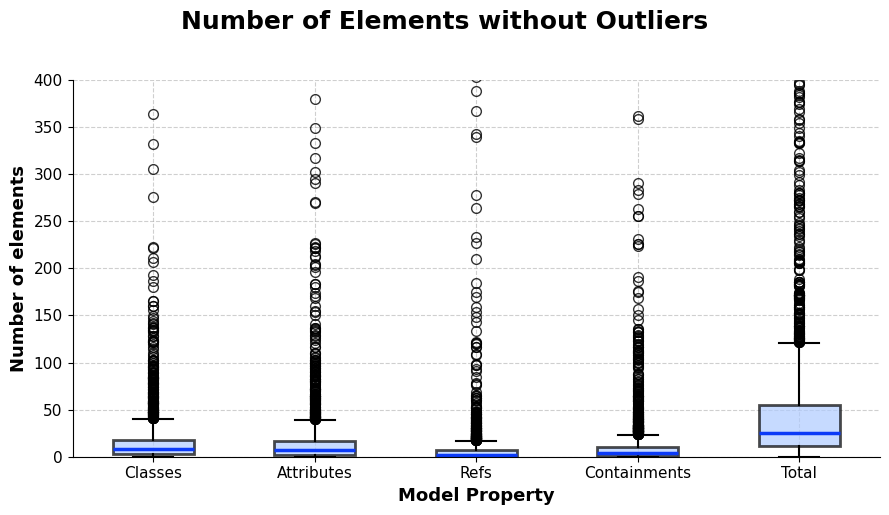

In [326]:
import pandas as pd
import matplotlib.pyplot as plt

valid_df = pd.read_csv('../results/RQ1/valid_models.csv')
props = ['classes', 'attributes', 'refs', 'containments']

valid_df['total'] = valid_df[props].sum(axis=1)
data = [valid_df[prop].values for prop in props] + [valid_df['total'].values]

fig, ax = plt.subplots(figsize=(9, 5))
fig.suptitle('Number of Elements without Outliers', fontsize=18, fontweight='bold', y=1.02)

box = ax.boxplot(
    data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props] + ['Total'],
    boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
    medianprops=dict(color="#0B3AF7", linewidth=2.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.8, markersize=7),   
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of elements', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim(0, 400)  

plt.tight_layout()
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\307432290.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


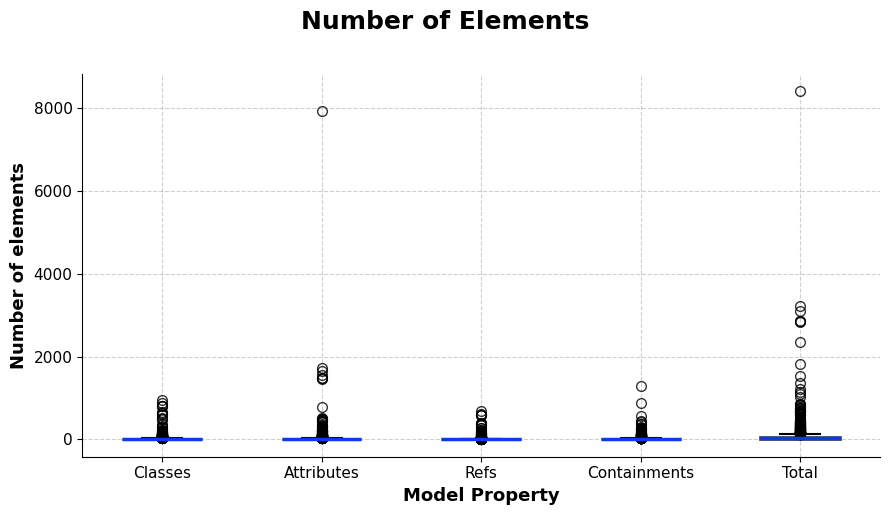

In [327]:
import pandas as pd
import matplotlib.pyplot as plt

valid_df = pd.read_csv('../results/RQ1/valid_models.csv')
props = ['classes', 'attributes', 'refs', 'containments']

valid_df['total'] = valid_df[props].sum(axis=1)
data = [valid_df[prop].values for prop in props] + [valid_df['total'].values]

fig, ax = plt.subplots(figsize=(9, 5))
fig.suptitle('Number of Elements', fontsize=18, fontweight='bold', y=1.02)

box = ax.boxplot(
    data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props] + ['Total'],
    boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
    medianprops=dict(color="#0B3AF7", linewidth=2.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.8, markersize=7),   
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of elements', fontsize=13, fontweight='bold')
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


plt.tight_layout()
plt.show()

# Results

In [328]:
import pandas as pd 
import glob

# Load valid models
valid_df = pd.read_csv('../results/RQ1/valid_models.csv')

# Find all models_run_*.csv files
run_files = glob.glob('../results/RQ1/models_run_*.csv')

dfs = []
for f in run_files:
    df = pd.read_csv(f)
    dfs.append(df)

# Combine all run files into a single DataFrame
runs_df = pd.concat([pd.read_csv(f) for f in run_files], ignore_index=True)

# Merge with valid_df on 'model' column (inner join keeps only valid models)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

# Now combined_df contains all run results with their corresponding valid model properties
combined_df.head()

,model,nodes,edges,time,mem,LOC,classes,attributes,refs,containments
0,.skriven,22,28,1123,9375,47,6,8,2,0
1,101companies,15,18,62,573,37,3,7,0,4
2,abapobj,191,213,273,1498,220,13,47,7,13
3,ABase,13,17,37,271,23,5,4,0,0
4,ABC,4,5,138,267,18,3,0,0,0


In [329]:
import pandas as pd
import glob


all_times = []
all_mem = []
for file in run_files:
    df = pd.read_csv(file)
    all_times.extend(df['time'].values)
    all_mem.extend(df['mem'].values)

all_times = pd.Series(all_times)
print(f"Number of runs analyzed: {len(run_files)}")
print(f"Min time: {all_times.min():.2f} ms")
print(f"Max time: {all_times.max():.2f} ms")
print(f"Avg time: {all_times.mean():.2f} ms")

all_mem = pd.Series(all_mem) 
print(f"Min memory: {all_mem.min():.2f} KB")
print(f"Max memory: {all_mem.max():.2f} KB")
print(f"Avg memory: {all_mem.mean():.2f} KB")

Number of runs analyzed: 5
Min time: 4.00 ms
Max time: 2159.00 ms
Avg time: 15.94 ms
Min memory: 168.00 KB
Max memory: 44043.00 KB
Avg memory: 892.10 KB


In [330]:
import pandas as pd  

dfs = [pd.read_csv(f) for f in run_files]
all_runs = pd.concat(dfs, ignore_index=True)

# Group by 'model' and compute the mean for each metric
avg_df = all_runs.groupby('model', as_index=False).mean(numeric_only=True)

# Get the top 10 models sorted by descending average time
avg_df = avg_df.sort_values('time', ascending=False)

avg_df.head(10)

,model,nodes,edges,time,mem
0,.skriven,22.0,28.0,709.6,9163.4
1855,scheduler,57.0,56.0,658.8,533.6
1358,format,9514.0,12936.0,564.0,43314.4
1028,atm,103.0,102.0,537.6,972.6
979,acad,69.0,68.0,535.6,881.4
889,UMLDI-ActivityGraphs,25.0,42.0,439.2,572.2
2041,vdx,1360.0,2340.0,374.4,5052.6
1884,sgraph,63.0,108.0,295.8,768.8
107,CIM15,4371.0,7722.0,275.8,18272.2
392,IFC2X4_RC3,5117.0,7391.0,251.4,14820.2


## Considering Time (ms)

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\3098442308.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


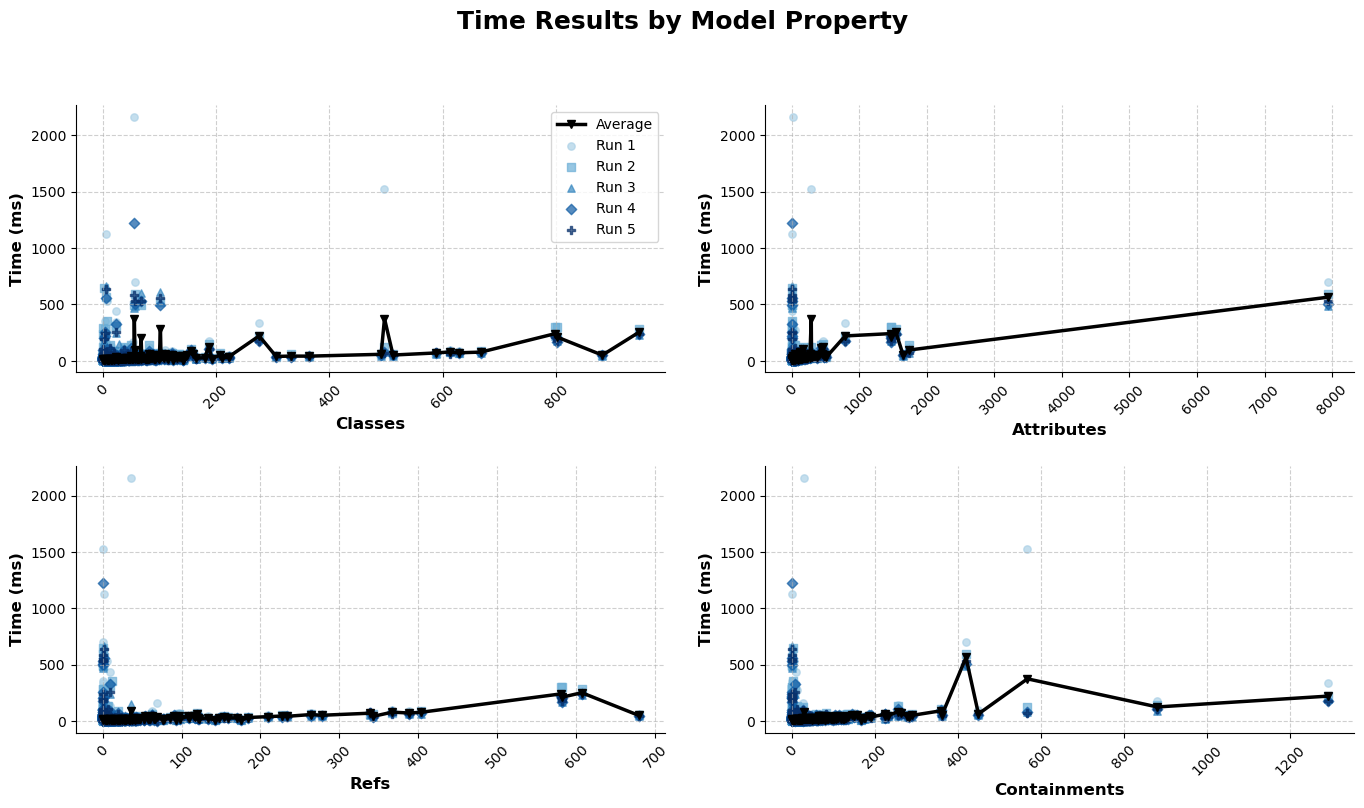

In [331]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['classes', 'attributes', 'refs', 'containments']
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']

# Run index to combined_df for coloring
for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Time Results by Model Property', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_times = combined_df.groupby(prop)['time'].mean()
    ax = axes[idx // 2, idx % 2]
    ax.plot(avg_times.index, avg_times.values, color="#000000", linewidth=2.5, label='Average', marker='v')
    for i in range(num_runs):
        run_df = combined_df[combined_df['run'] == i]
        marker_style = markers[i % len(markers)]
        ax.scatter(run_df[prop], run_df['time'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if idx == 0:
        ax.legend(fontsize=10, loc='best')
    # ax.set_xlim(0, 2000)  
plt.tight_layout(pad=2)
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\1771096284.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


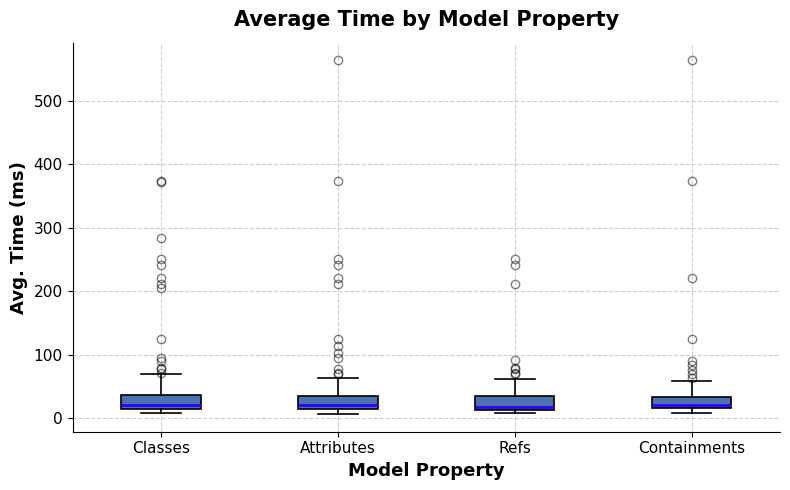

In [332]:
import matplotlib.pyplot as plt 

props = ['classes', 'attributes', 'refs', 'containments']
avg_time_data = [combined_df.groupby(prop)['time'].mean().values for prop in props]

fig, ax = plt.subplots(figsize=(8, 5))

box = ax.boxplot(
    avg_time_data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props],
    boxprops=dict(facecolor='#4C72B0', color='black', linewidth=1.2),
    medianprops=dict(color="#2F00FF", linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.2),
    capprops=dict(color='black', linewidth=1.2),
    flierprops=dict(marker='o', color='gray', alpha=0.5)
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Avg. Time (ms)', fontsize=13, fontweight='bold')
ax.set_title('Average Time by Model Property', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\2410589682.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


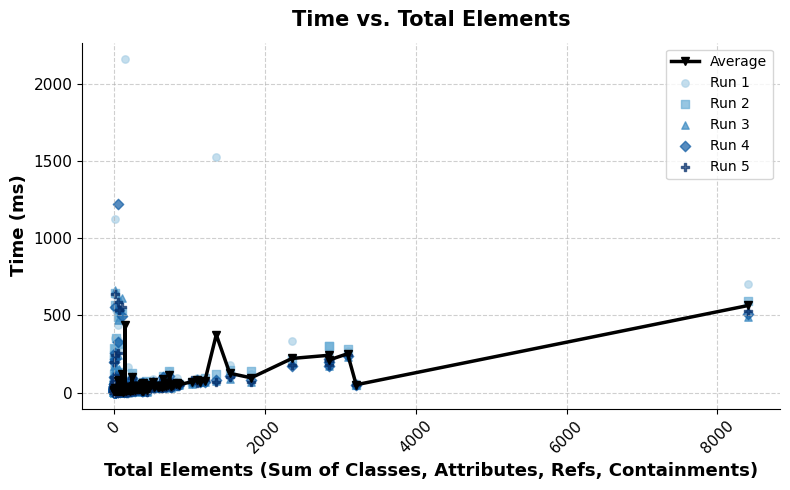

In [333]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

valid_df['total_structural'] = valid_df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)
model_total_structural = valid_df.set_index('model')['total_structural'] 
for df in dfs:
    df['total_structural'] = df['model'].map(model_total_structural) 
combined_df_total = pd.concat(dfs)
 
avg_times = combined_df_total.groupby('total_structural')['time'].mean()
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(avg_times.index, avg_times.values, color="#000000", linewidth=2.5, label='Average', marker='v')

markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']
for i, df in enumerate(dfs):
    marker_style = markers[i % len(markers)]
    ax.scatter(df['total_structural'], df['time'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
ax.set_xlabel('Total Elements (Sum of Classes, Attributes, Refs, Containments)', fontsize=13, fontweight='bold')
ax.set_ylabel('Time (ms)', fontsize=13, fontweight='bold')
ax.set_title('Time vs. Total Elements', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11, rotation=45)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=10, loc='best')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# ax.set_xlim(0, 3300) 
plt.tight_layout()
plt.show()

## Considering memory (KB)

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\2036468278.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


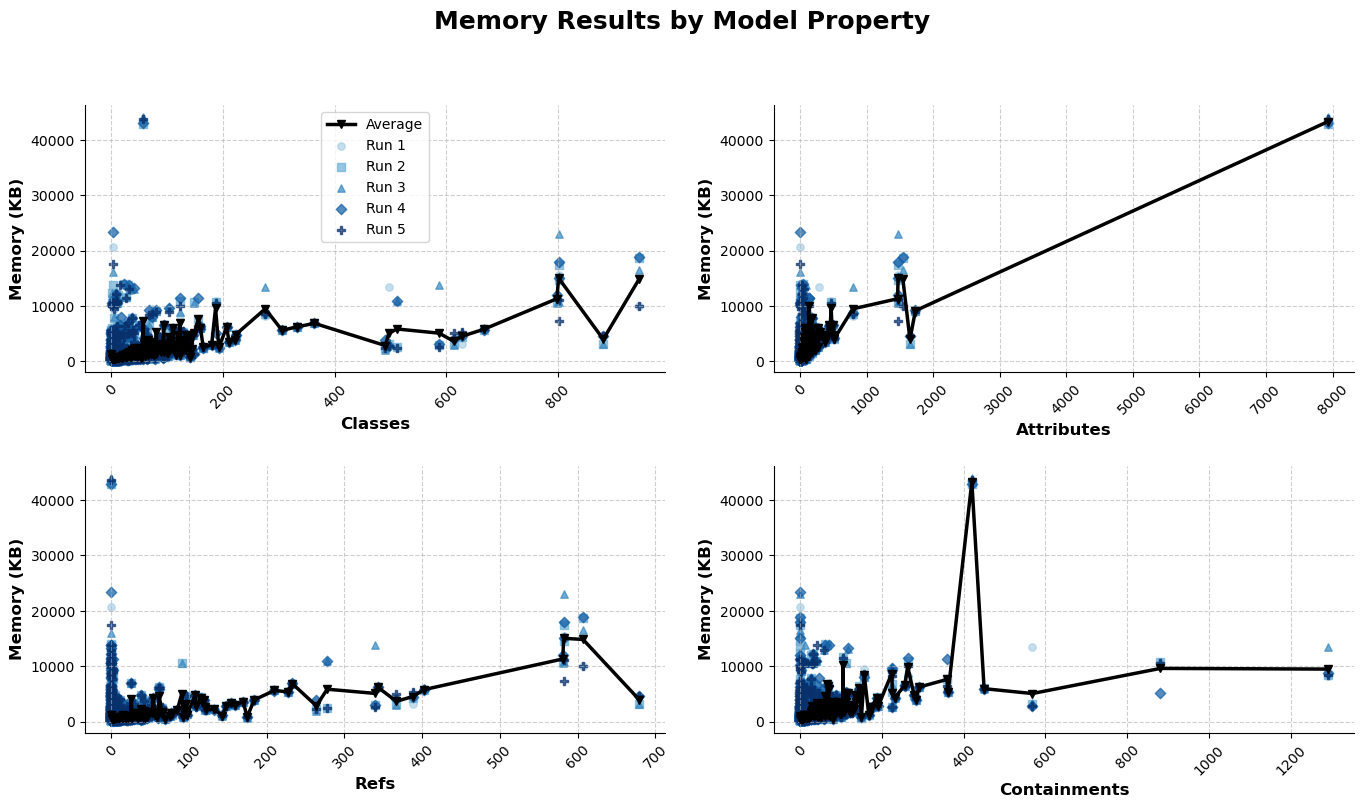

In [334]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['classes', 'attributes', 'refs', 'containments']
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']

# Run index to combined_df for coloring
for i, df in enumerate(dfs):
    df['run'] = i
runs_df = pd.concat(dfs, ignore_index=True)
combined_df = pd.merge(runs_df, valid_df, on='model', suffixes=('_run', '_model'))

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Memory Results by Model Property', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_mem = combined_df.groupby(prop)['mem'].mean()
    ax = axes[idx // 2, idx % 2]
    ax.plot(avg_mem.index, avg_mem.values, color="#000000", linewidth=2.5, label='Average', marker='v')
    for i in range(num_runs):
        run_df = combined_df[combined_df['run'] == i]
        marker_style = markers[i % len(markers)]
        ax.scatter(run_df[prop], run_df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory (KB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if idx == 0:
        ax.legend(fontsize=10, loc='best')

plt.tight_layout(pad=2)
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\1527332675.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


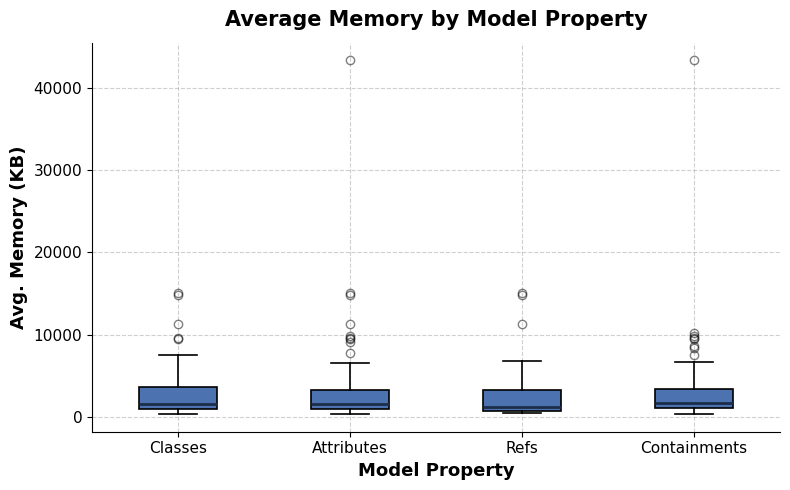

In [335]:
import matplotlib.pyplot as plt 

props = ['classes', 'attributes', 'refs', 'containments']
avg_mem_data = [combined_df.groupby(prop)['mem'].mean().values for prop in props]

fig, ax = plt.subplots(figsize=(8, 5))

box = ax.boxplot(
    avg_mem_data,
    vert=True,
    patch_artist=True,
    labels=[p.capitalize() for p in props],
    boxprops=dict(facecolor='#4C72B0', color='black', linewidth=1.2),
    medianprops=dict(color="#1B2D49", linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.2),
    capprops=dict(color='black', linewidth=1.2),
    flierprops=dict(marker='o', color='gray', alpha=0.5)
)

ax.set_xlabel('Model Property', fontsize=13, fontweight='bold')
ax.set_ylabel('Avg. Memory (KB)', fontsize=13, fontweight='bold')
ax.set_title('Average Memory by Model Property', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\1545728255.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


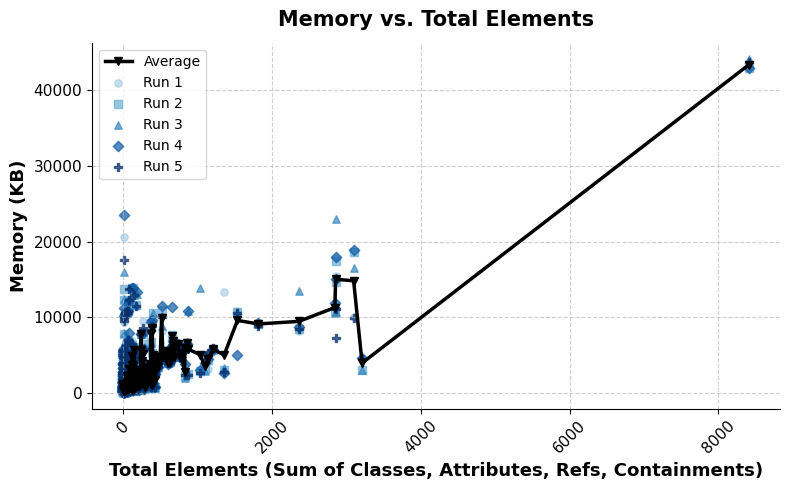

In [336]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

valid_df['total_structural'] = valid_df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)
model_total_structural = valid_df.set_index('model')['total_structural']


for df in dfs:
    df['total_structural'] = df['model'].map(model_total_structural)


combined_df_total = pd.concat(dfs)  
avg_mems = combined_df_total.groupby('total_structural')['mem'].mean()

fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(avg_mems.index, avg_mems.values, color="#000000", linewidth=2.5, label='Average', marker='v')


markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']
for i, df in enumerate(dfs):
    marker_style = markers[i % len(markers)]
    ax.scatter(df['total_structural'], df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
ax.set_xlabel('Total Elements (Sum of Classes, Attributes, Refs, Containments)', fontsize=13, fontweight='bold')
ax.set_ylabel('Memory (KB)', fontsize=13, fontweight='bold')
ax.set_title('Memory vs. Total Elements', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11, rotation=45)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=10, loc='best')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# ax.set_xlim(0, 3300) 
plt.tight_layout()
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\2777574480.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


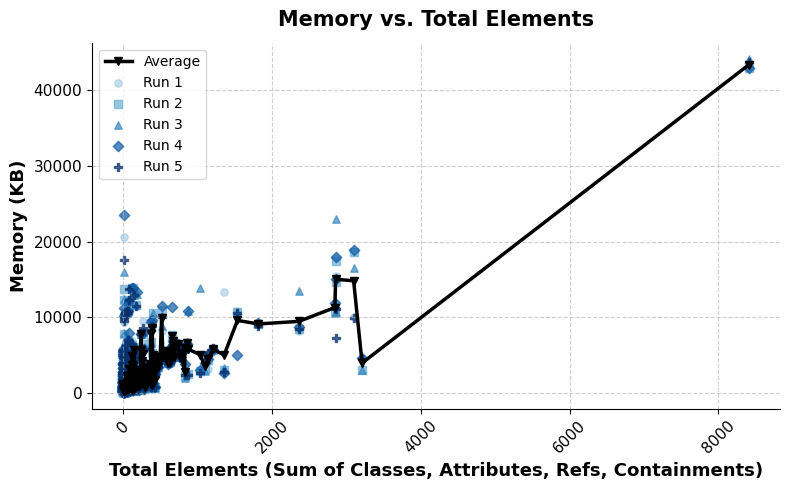

In [337]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

valid_df['total_structural'] = valid_df[['classes', 'attributes', 'refs', 'containments']].sum(axis=1)
model_total_structural = valid_df.set_index('model')['total_structural']


for df in dfs:
    df['total_structural'] = df['model'].map(model_total_structural)


combined_df_total = pd.concat(dfs)  
avg_mems = combined_df_total.groupby('total_structural')['mem'].mean()

fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(avg_mems.index, avg_mems.values, color="#000000", linewidth=2.5, label='Average', marker='v')


markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']
for i, df in enumerate(dfs):
    marker_style = markers[i % len(markers)]
    ax.scatter(df['total_structural'], df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
ax.set_xlabel('Total Elements (Sum of Classes, Attributes, Refs, Containments)', fontsize=13, fontweight='bold')
ax.set_ylabel('Memory (KB)', fontsize=13, fontweight='bold')
ax.set_title('Memory vs. Total Elements', fontsize=15, fontweight='bold', pad=12)
ax.tick_params(axis='x', labelsize=11, rotation=45)
ax.tick_params(axis='y', labelsize=11)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=10, loc='best')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


# ax.set_xlim(0, 3200) 

plt.tight_layout()
plt.show()

## Considering the size of the graphs (nodes and edges)

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\693807635.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


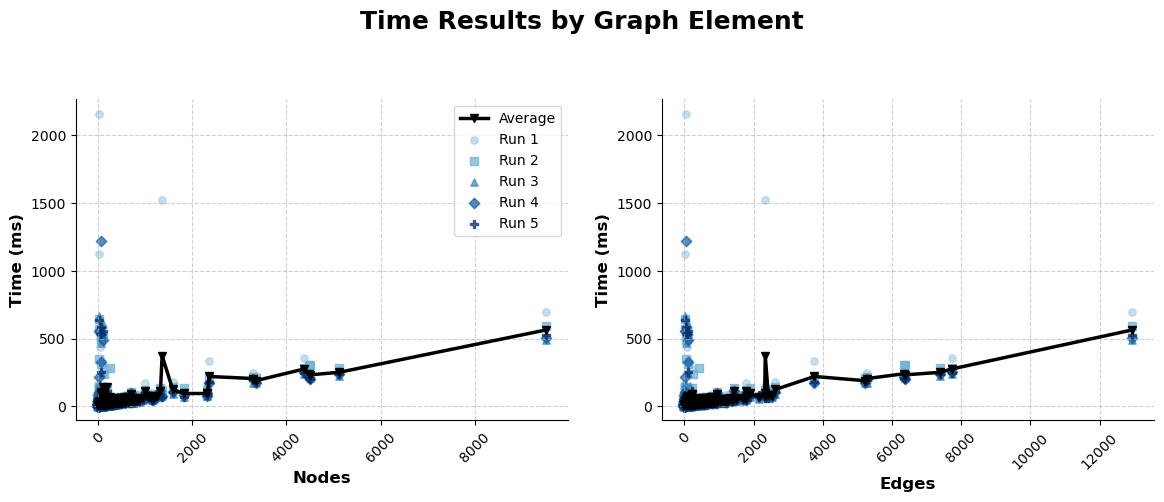

In [338]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['nodes', 'edges']
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Time Results by Graph Element', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_time = combined_df.groupby(prop)['time'].mean()
    ax = axes[idx]
    # Plot average line
    ax.plot(avg_time.index, avg_time.values, color="#000000", linewidth=2.5, label='Average', marker='v')
    # Plot each run with a different marker
    for i, df in enumerate(dfs):
        marker_style = markers[i % len(markers)]
        ax.scatter(df[prop], df['time'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if idx == 0:
        ax.legend(fontsize=10, loc='best')

plt.tight_layout(pad=2)
plt.show()

C:\Users\lamp6\AppData\Local\Temp\ipykernel_2260\184290592.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap('Blues', num_runs + 2)


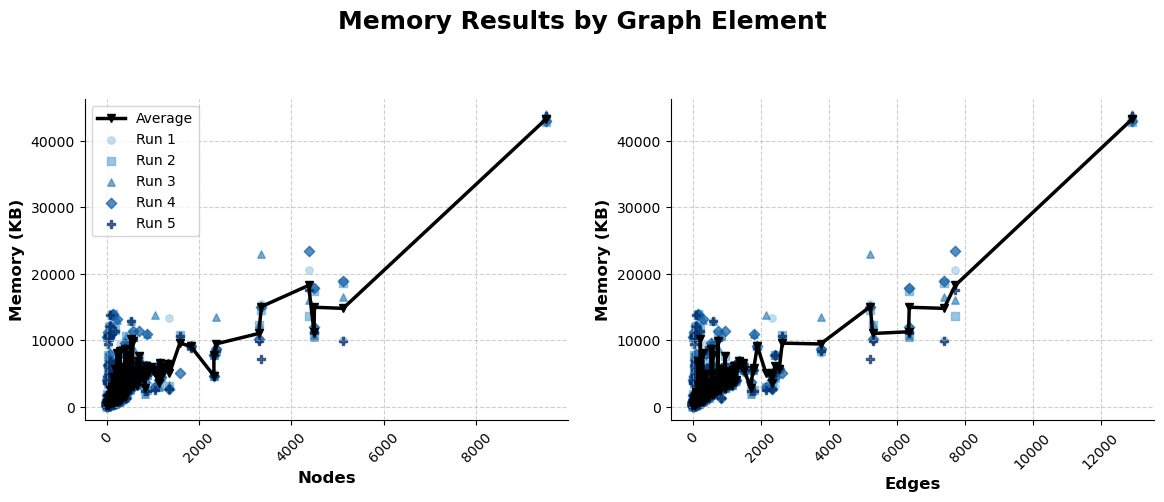

In [339]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

num_runs = len(dfs)
blues = cm.get_cmap('Blues', num_runs + 2)
colors = [blues(i + 2) for i in range(num_runs)]

props = ['nodes', 'edges']
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Memory Results by Graph Element', fontsize=18, fontweight='bold', y=1.02)

for idx, prop in enumerate(props):
    avg_mem = combined_df.groupby(prop)['mem'].mean()
    ax = axes[idx]
    # Plot average line
    ax.plot(avg_mem.index, avg_mem.values, color="#000000", linewidth=2.5, label='Average', marker='v')
    # Plot each run with a different marker
    for i, df in enumerate(dfs):
        marker_style = markers[i % len(markers)]
        ax.scatter(df[prop], df['mem'], label=f'Run {i+1}', alpha=0.7, s=28, marker=marker_style, color=colors[i])
    ax.set_xlabel(prop.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory (KB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    if idx == 0:
        ax.legend(fontsize=10, loc='best')

plt.tight_layout(pad=2)
plt.show()

## Create Operations

#### Create Single

In [340]:
import pandas as pd
import glob

# Find all CreateSingle_run_*.csv files
create_run_files = glob.glob('../results/RQ2/CreateSingle/CreateSingle_run_*.csv')

# Load and concatenate all runs
create_runs = pd.concat([pd.read_csv(f) for f in create_run_files], ignore_index=True)

ordered_create_runs = create_runs.sort_values('time',ascending=False)

ordered_create_runs.head(10)

,element_count,time,mem
44,100000,1349,56957
8,100000,909,62674
35,100000,882,65881
17,100000,867,62795
26,100000,864,66249
43,50000,831,69670
7,50000,581,53154
34,50000,575,62067
16,50000,570,62860
25,50000,565,59789


In [341]:
# Group by element count
group_col = 'element_count' 

grouped = create_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,140.6,135,145,2092.2,2004,2380
1,50,128.4,123,134,437.8,369,511
2,100,132.4,124,136,539.8,483,608
3,500,138.6,132,151,1336.4,1299,1410
4,1000,136.4,126,141,2010.2,1966,2040
5,5000,191.4,181,200,9039.4,9030,9052
6,10000,233.2,213,274,11259.2,11138,11406
7,50000,624.4,565,831,61508.0,53154,69670
8,100000,974.2,864,1349,62911.2,56957,66249


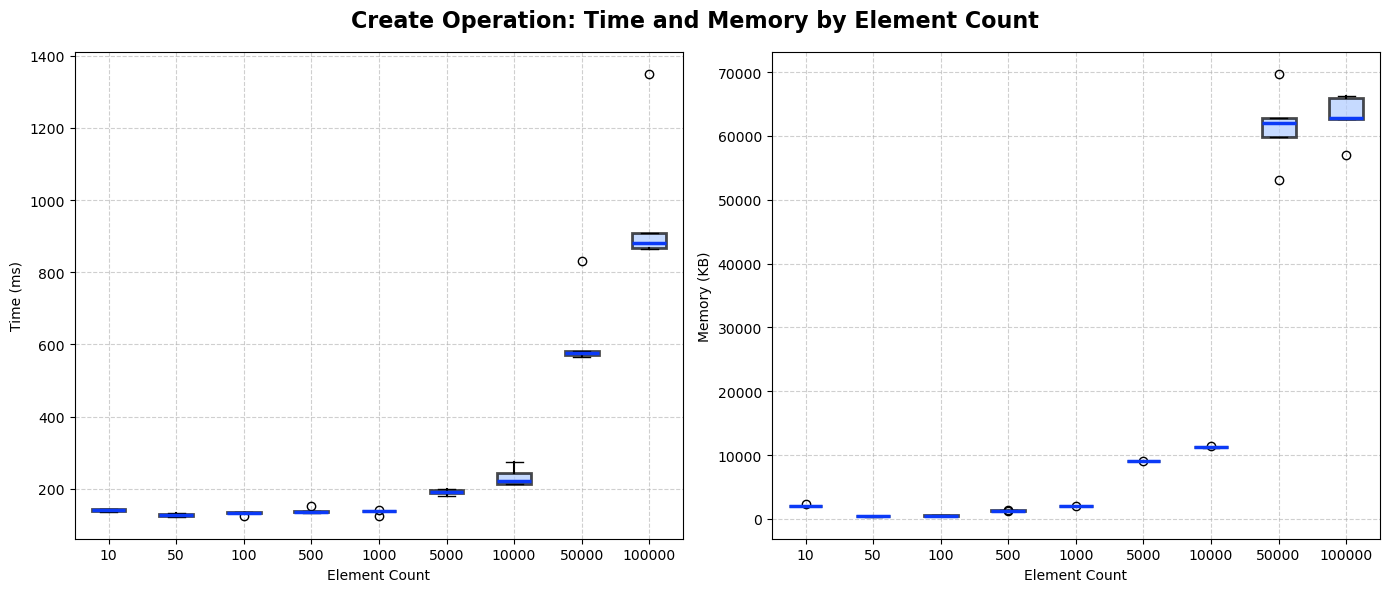

In [342]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
create_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
create_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Create Operation: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Create Containment Width

In [343]:
import pandas as pd
import glob

# Find all CreateContainmentWidth_run_*.csv files
create_containment_run_files = glob.glob('../results/RQ2/CreateContainmentWidth/CreateContainmentWidth_run_*.csv')

# Load and concatenate all runs
create_containment_runs = pd.concat([pd.read_csv(f) for f in create_containment_run_files], ignore_index=True)

ordered_create_runs_containment = create_containment_runs.sort_values('time',ascending=False)

ordered_create_runs.head(10)

,element_count,time,mem
44,100000,1349,56957
8,100000,909,62674
35,100000,882,65881
17,100000,867,62795
26,100000,864,66249
43,50000,831,69670
7,50000,581,53154
34,50000,575,62067
16,50000,570,62860
25,50000,565,59789


In [344]:
# Group by element count
group_col = 'element_count' 

grouped_containment = create_containment_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_containment.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,150.0,143,165,2248.0,2112,2433
1,50,145.8,138,152,869.4,806,896
2,100,135.0,129,141,855.6,796,930
3,500,152.6,145,160,2017.6,1948,2086
4,1000,158.6,150,166,3357.8,3295,3438
5,5000,251.6,236,296,8281.2,8045,8394
6,10000,376.4,353,423,17183.4,15059,17939
7,50000,1049.2,974,1199,80131.4,57855,118249
8,100000,1759.4,1680,1882,107701.2,90160,150284


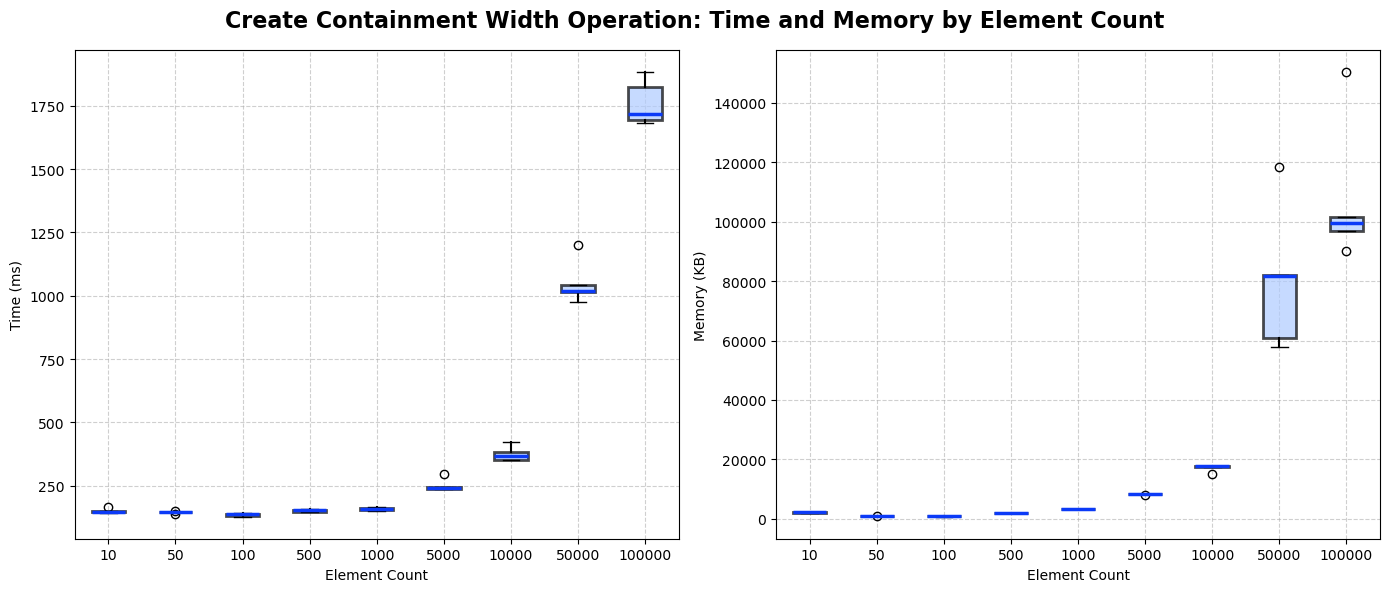

In [345]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
create_containment_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
create_containment_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Create Containment Width Operation: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Create Containment Depth

In [346]:
import pandas as pd
import glob

# Find all CreateContainmentDepth_run_*.csv files
create_containment_d_run_files = glob.glob('../results/RQ2/CreateContainmentDepth/CreateContainmentDepth_run_*.csv')

# Load and concatenate all runs
create_containment_d_runs = pd.concat([pd.read_csv(f) for f in create_containment_d_run_files], ignore_index=True)

ordered_create_runs_containment = create_containment_d_runs.sort_values('time',ascending=False)

ordered_create_runs.head(10)

,element_count,time,mem
44,100000,1349,56957
8,100000,909,62674
35,100000,882,65881
17,100000,867,62795
26,100000,864,66249
43,50000,831,69670
7,50000,581,53154
34,50000,575,62067
16,50000,570,62860
25,50000,565,59789


In [347]:
# Group by element count
group_col = 'element_count' 

grouped_containment_d = create_containment_d_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_containment_d.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,144.2,138,152,1406.4,1312,1645
1,50,139.2,134,147,826.4,779,875
2,100,134.4,132,136,836.6,728,931
3,500,148.4,140,157,2201.2,2085,2261
4,1000,155.0,147,163,3763.6,3748,3794
5,5000,261.6,237,291,10955.6,10319,11348
6,10000,352.0,332,374,20917.2,19556,22446
7,50000,947.4,910,1010,85843.6,72842,93878
8,100000,1637.6,1523,1684,163850.0,141185,181975


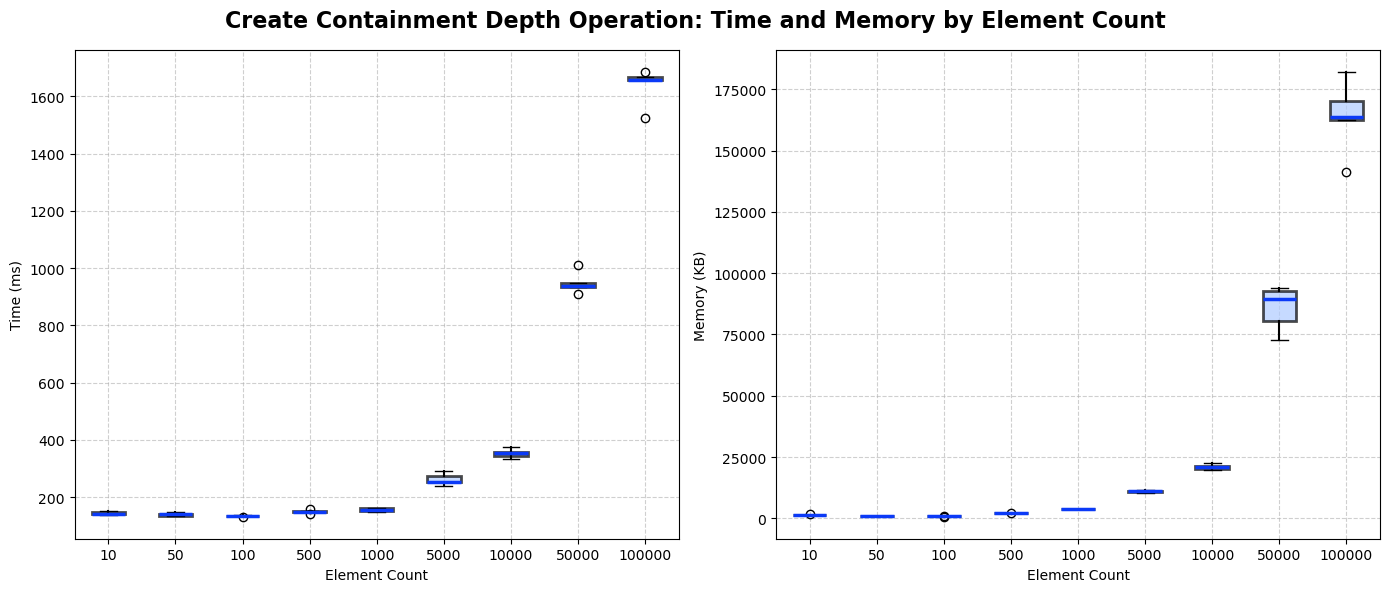

In [348]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
create_containment_d_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
create_containment_d_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Create Containment Depth Operation: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Create Cross Ref

In [349]:
import pandas as pd
import glob

# Find all CreateContainmentWidth_run_*.csv files
create_cross_ref_run_files = glob.glob('../results/RQ2/CreateCrossRef/CreateCrossRef_run_*.csv')

# Load and concatenate all runs
create_cross_ref_run = pd.concat([pd.read_csv(f) for f in create_cross_ref_run_files], ignore_index=True)

ordered_create_cross_ref_run = create_cross_ref_run.sort_values('time',ascending=False)

ordered_create_cross_ref_run.head(10)

,element_count,time,mem
8,100000,1430,32679
35,100000,1360,38595
44,100000,1316,38817
26,100000,1314,69501
17,100000,1273,64634
7,50000,844,23369
34,50000,827,29212
16,50000,825,28600
25,50000,799,26343
43,50000,779,28683


In [350]:
# Group by element count
group_col = 'element_count' 

grouped_cross_ref = create_cross_ref_run.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_cross_ref.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,123.2,117,128,405.4,362,426
1,50,131.8,129,134,572.4,470,657
2,100,126.4,120,133,551.0,472,647
3,500,133.4,127,146,1132.4,1067,1195
4,1000,138.4,131,146,1462.4,1430,1516
5,5000,183.8,177,192,5584.6,5567,5623
6,10000,234.2,223,241,10323.4,10143,10614
7,50000,814.8,779,844,27241.4,23369,29212
8,100000,1338.6,1273,1430,48845.2,32679,69501


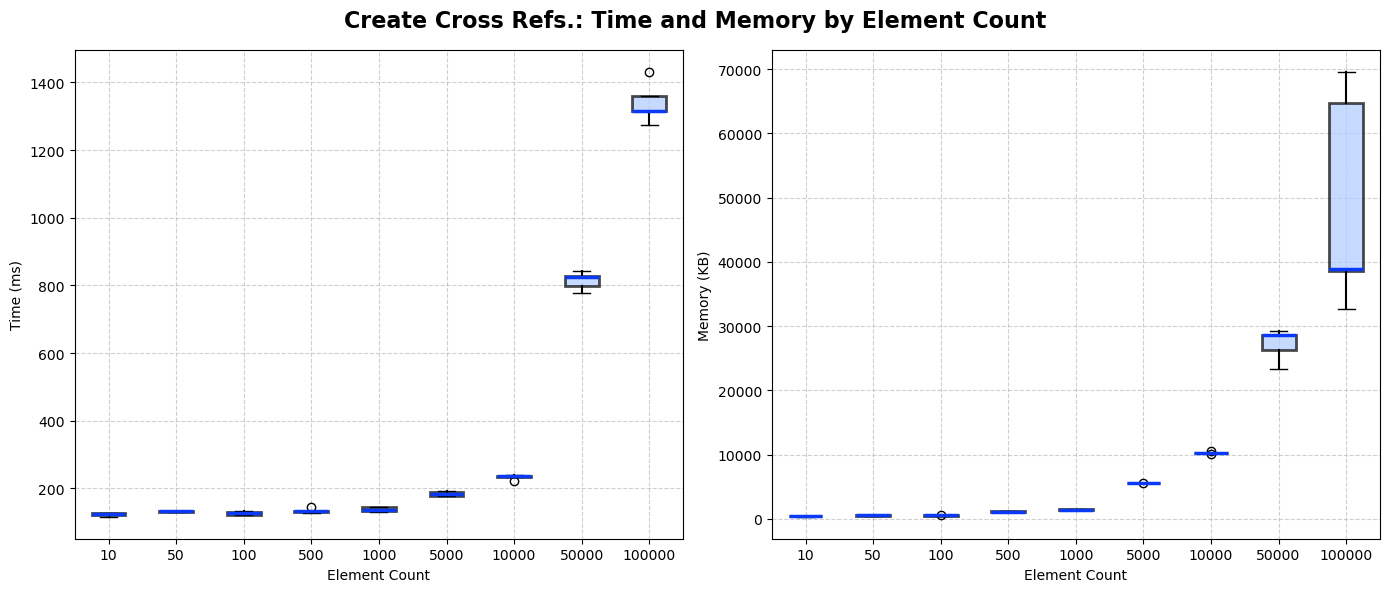

In [351]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
create_cross_ref_run.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
create_cross_ref_run.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Create Cross Refs.: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Read Operations

### Read 

In [352]:
import pandas as pd
import glob

 
read_run_files = glob.glob('../results/RQ2/Read/Read_run_*.csv')

# Load and concatenate all runs
read_runs = pd.concat([pd.read_csv(f) for f in read_run_files], ignore_index=True)

ordered_read_runs = read_runs.sort_values('time',ascending=False)

ordered_read_runs.head(10)

,element_count,time,mem
44,100000,552,49185
26,100000,535,51728
8,100000,477,48447
17,100000,469,65175
35,100000,465,43195
43,50000,349,37135
34,50000,290,28803
7,50000,282,27006
16,50000,274,39945
25,50000,271,34068


In [353]:
# Group by element count
group_col = 'element_count' 

grouped_read = read_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,124.4,116,134,366.6,333,400
1,50,120.8,110,125,375.4,318,446
2,100,124.8,121,128,338.0,300,388
3,500,125.8,124,129,806.4,722,914
4,1000,124.0,121,126,1560.4,1422,1657
5,5000,137.4,134,141,6183.2,6121,6363
6,10000,150.4,145,155,13665.4,13612,13720
7,50000,293.2,271,349,33391.4,27006,39945
8,100000,499.6,465,552,51546.0,43195,65175


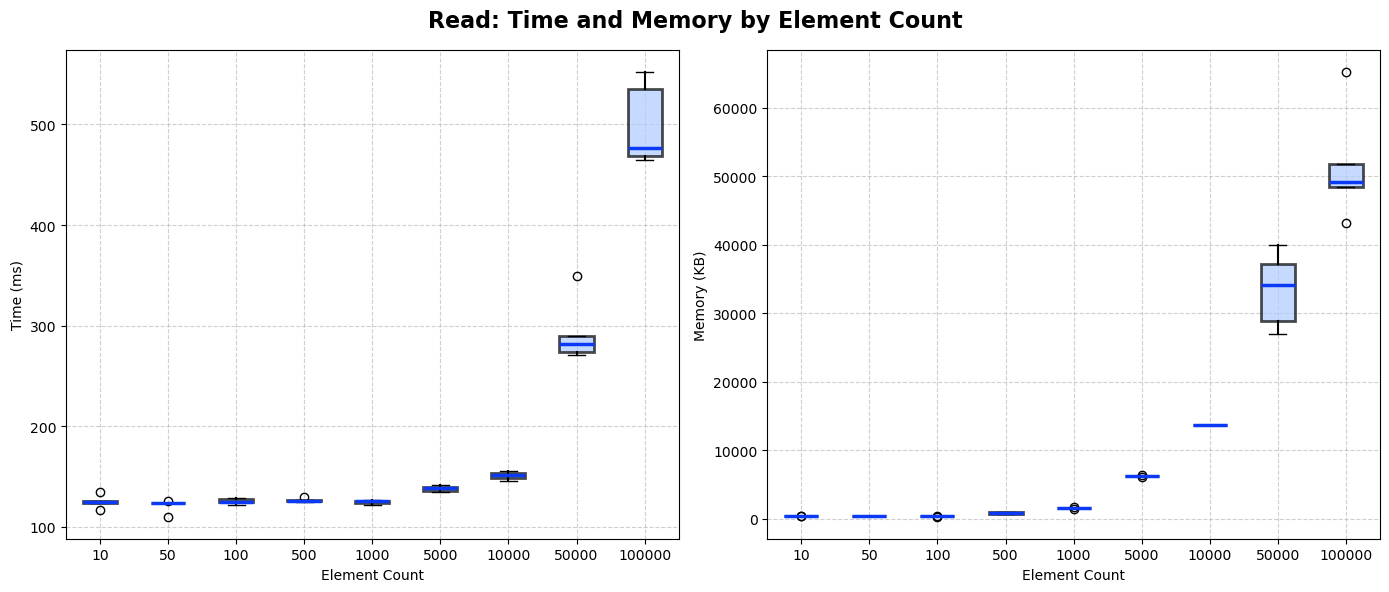

In [354]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
read_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
read_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Read: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Read Containment Width

In [355]:
import pandas as pd
import glob

 
read_c_w_run_files = glob.glob('../results/RQ2/ReadContainmentWidth/ReadContainmentWidth_run_*.csv')

# Load and concatenate all runs
read_c_w_runs = pd.concat([pd.read_csv(f) for f in read_c_w_run_files], ignore_index=True)

ordered_read_c_w_runs = read_c_w_runs.sort_values('time',ascending=False)

ordered_read_c_w_runs.head(10)

,element_count,time,mem
44,100000,531,53460
8,100000,528,36723
35,100000,515,34295
17,100000,480,44810
26,100000,472,38625
43,50000,309,34694
16,50000,293,36356
7,50000,290,19944
25,50000,281,22008
34,50000,270,34806


In [356]:
# Group by element count
group_col = 'element_count' 

grouped_read_c_w_runs = read_c_w_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read_c_w_runs.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,148.0,123,215,404.4,385,416
1,50,122.8,119,130,370.6,344,397
2,100,123.8,122,125,351.6,342,366
3,500,125.0,124,126,777.2,738,796
4,1000,125.0,124,126,1425.0,1347,1479
5,5000,135.6,132,138,5504.2,5443,5573
6,10000,155.8,150,168,11802.2,11717,12101
7,50000,288.6,270,309,29561.6,19944,36356
8,100000,505.2,472,531,41582.6,34295,53460


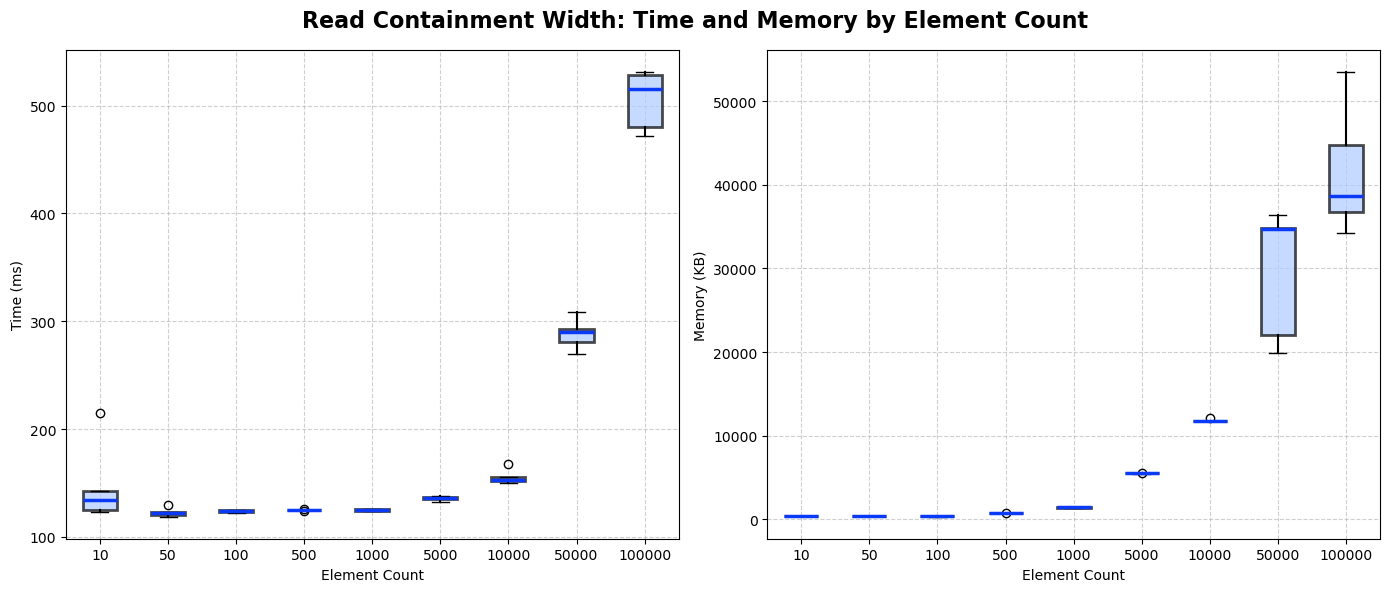

In [357]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
read_c_w_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
read_c_w_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Read Containment Width: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Read Containment Depth

In [358]:
import pandas as pd
import glob

 
read_c_d_run_files = glob.glob('../results/RQ2/ReadContainmentDepth/ReadContainmentDepth_run_*.csv')

# Load and concatenate all runs
read_c_d_runs = pd.concat([pd.read_csv(f) for f in read_c_d_run_files], ignore_index=True)

ordered_read_c_d_runs = read_c_d_runs.sort_values('time',ascending=False)

ordered_read_c_d_runs.head(10)

,element_count,time,mem
35,100000,517,43594
17,100000,494,56710
44,100000,489,65389
8,100000,464,67137
26,100000,457,70844
7,50000,354,27189
34,50000,322,40559
16,50000,310,49668
43,50000,294,27257
25,50000,293,34407


In [359]:
# Group by element count
group_col = 'element_count' 

grouped_read_c_w_runs = read_c_w_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read_c_w_runs.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,148.0,123,215,404.4,385,416
1,50,122.8,119,130,370.6,344,397
2,100,123.8,122,125,351.6,342,366
3,500,125.0,124,126,777.2,738,796
4,1000,125.0,124,126,1425.0,1347,1479
5,5000,135.6,132,138,5504.2,5443,5573
6,10000,155.8,150,168,11802.2,11717,12101
7,50000,288.6,270,309,29561.6,19944,36356
8,100000,505.2,472,531,41582.6,34295,53460


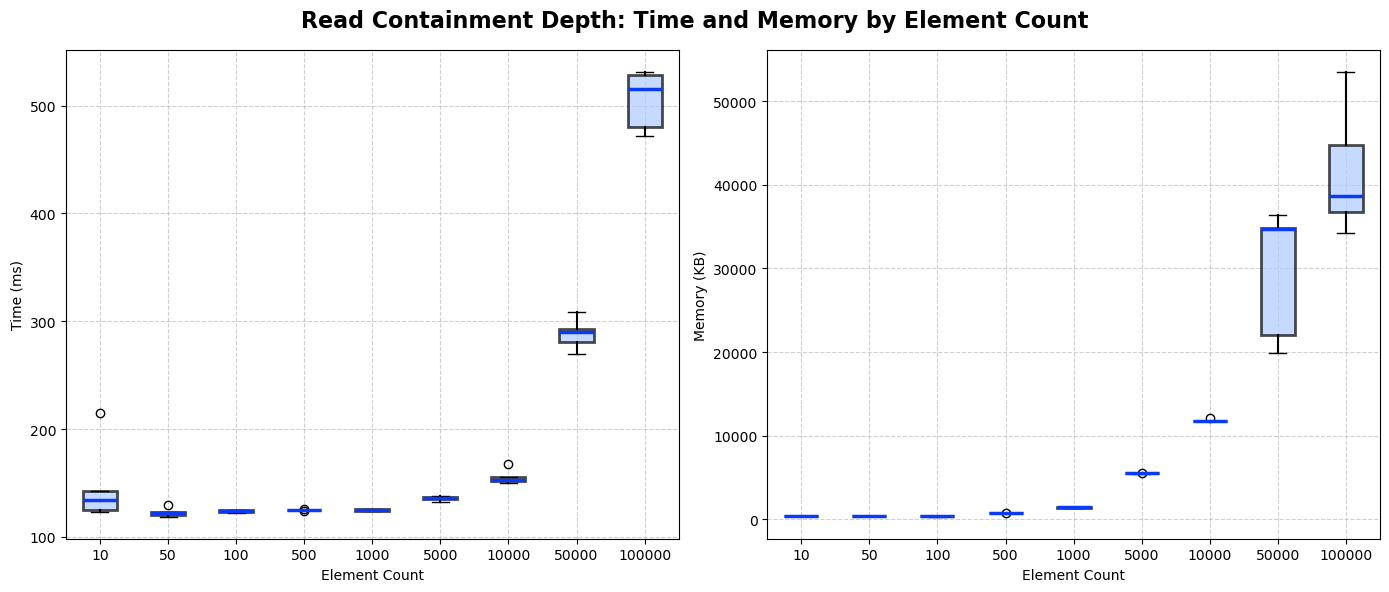

In [360]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
read_c_w_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
read_c_w_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Read Containment Depth: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Read Cross Ref

In [361]:
import pandas as pd
import glob

 
read_cross_ref_run_files = glob.glob('../results/RQ2/ReadCrossRef/ReadCrossRef_run_*.csv')

# Load and concatenate all runs
read_cross_ref_runs = pd.concat([pd.read_csv(f) for f in read_cross_ref_run_files], ignore_index=True)

ordered_read_cross_ref_runs = read_cross_ref_runs.sort_values('time',ascending=False)

ordered_read_cross_ref_runs.head(10)

,element_count,time,mem
18,10,129,431
36,10,129,426
27,10,127,496
9,10,127,418
5,5000,126,354
13,1000,126,335
30,500,126,399
40,1000,126,378
24,10000,126,373
20,100,126,399


In [362]:
# Group by element count
group_col = 'element_count' 

grouped_read_cross_ref_runs = read_cross_ref_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read_cross_ref_runs.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,125.6,116,129,436.0,409,496
1,50,122.2,121,123,399.4,375,436
2,100,122.0,113,126,381.6,361,399
3,500,125.0,124,126,372.0,352,399
4,1000,125.2,124,126,369.2,335,399
5,5000,124.0,123,126,363.0,335,392
6,10000,124.0,122,126,359.2,335,392
7,50000,123.4,122,124,369.0,335,392
8,100000,124.4,123,126,387.6,345,422


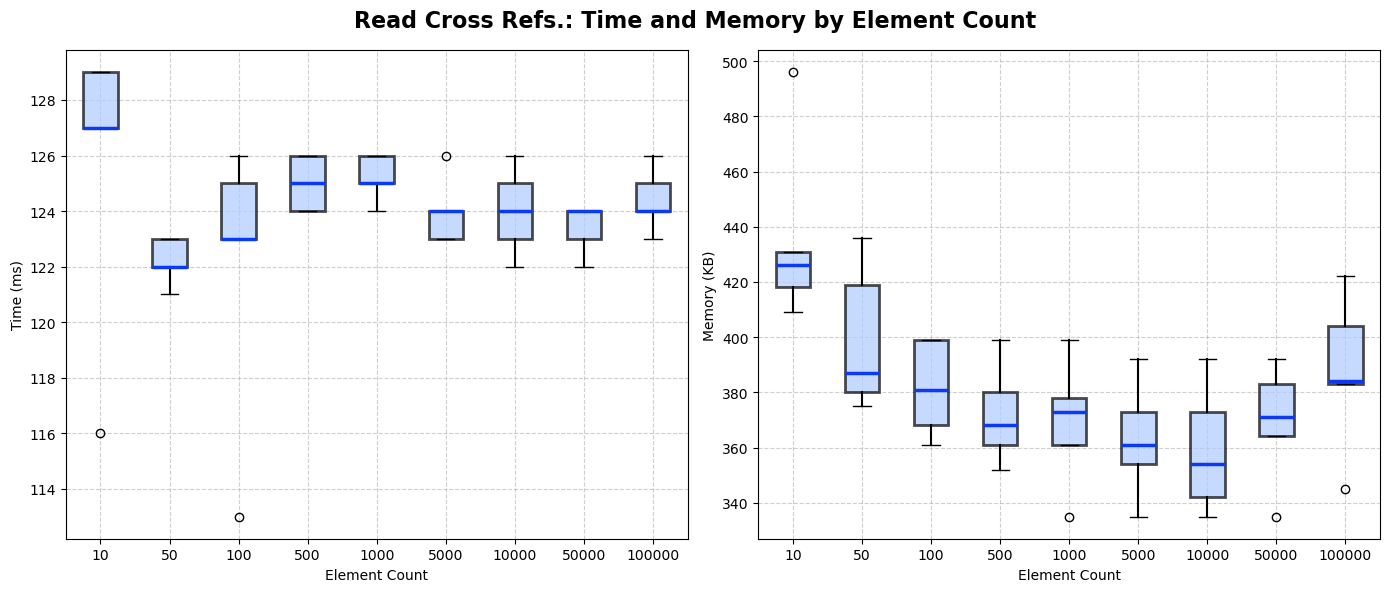

In [363]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
read_cross_ref_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
read_cross_ref_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Read Cross Refs.: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Update Operations

### Update

In [364]:
import pandas as pd
import glob

 
update_run_files = glob.glob('../results/RQ2/Update/Update_run_*.csv')

# Load and concatenate all runs
update_runs = pd.concat([pd.read_csv(f) for f in update_run_files], ignore_index=True)

ordered_update_runs = update_runs.sort_values('time',ascending=False)

ordered_update_runs.head(10)

,element_count,time,mem
0,10,371,1024
7,50000,323,32768
17,100000,314,43008
35,100000,312,43008
43,50000,312,32768
26,100000,306,43008
44,100000,297,43008
34,50000,291,32768
8,100000,291,43008
25,50000,286,32768


In [365]:
# Group by element count
group_col = 'element_count' 

grouped_update_runs = update_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_update_runs.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,196.0,148,371,1024.0,1024,1024
1,50,158.0,135,194,1024.0,1024,1024
2,100,144.8,137,156,1024.0,1024,1024
3,500,153.0,142,190,1538.0,1538,1538
4,1000,145.2,140,157,2048.0,2048,2048
5,5000,188.2,168,252,7349.4,7047,7682
6,10000,219.8,201,243,13371.2,13304,13614
7,50000,296.6,271,323,32768.0,32768,32768
8,100000,304.0,291,314,43008.0,43008,43008


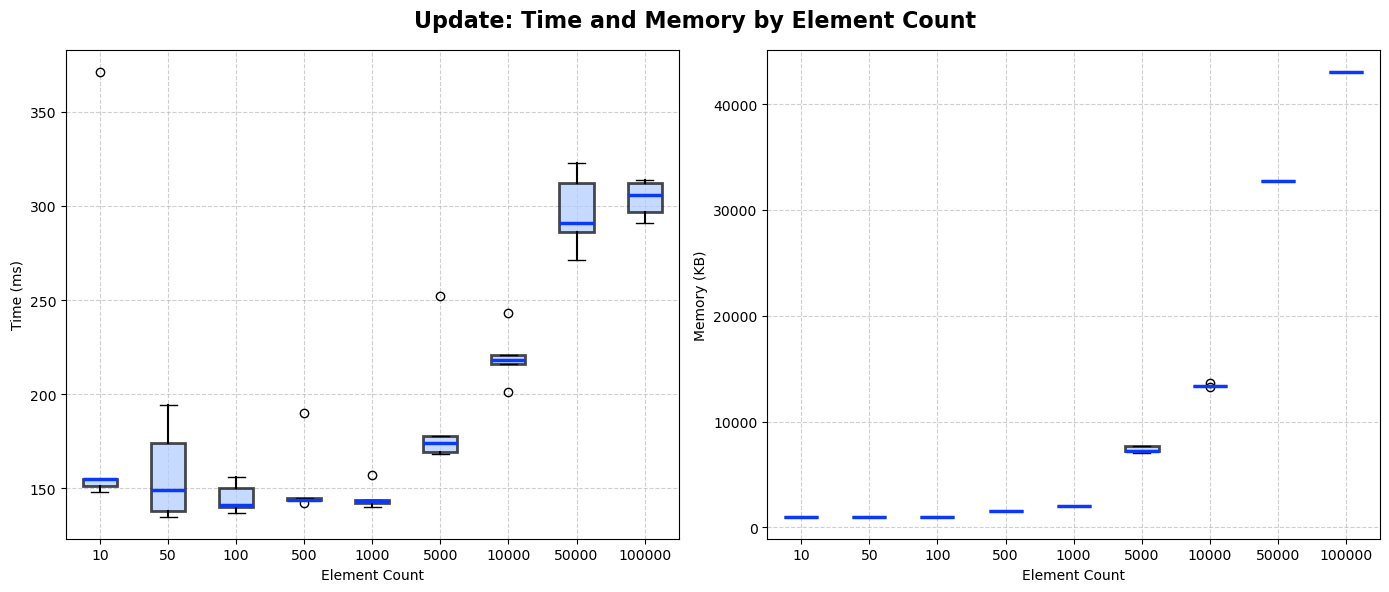

In [367]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
update_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
update_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Update: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Delete Operations

### Delete Single

In [368]:
import pandas as pd
import glob

 
delete_s_run_files = glob.glob('../results/RQ2/DeleteSingle/DeleteSingle_run_*.csv')

# Load and concatenate all runs
delete_s_runs = pd.concat([pd.read_csv(f) for f in delete_s_run_files], ignore_index=True)

ordered_delete_s_runs = delete_s_runs.sort_values('time',ascending=False)

ordered_delete_s_runs.head(10)

,element_count,time,mem
36,10,550,393
43,50000,437,36274
35,100000,325,51312
25,50000,324,36781
8,100000,316,20183
44,100000,314,11836
17,100000,294,49018
16,50000,289,34356
26,100000,289,51129
7,50000,276,35103


In [369]:
# Group by element count
group_col = 'element_count' 

grouped_delete_s_runs = delete_s_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_delete_s_runs.head(10)

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,209.2,118,550,395.6,307,512
1,50,146.2,128,210,482.6,313,652
2,100,127.8,119,132,452.6,284,568
3,500,142.4,125,198,1207.4,1115,1255
4,1000,134.6,126,150,2056.8,2048,2092
5,5000,184.0,168,245,7133.4,3938,9269
6,10000,194.0,189,200,9694.2,6803,11091
7,50000,319.4,271,437,35615.0,34356,36781
8,100000,307.6,289,325,36695.6,11836,51312


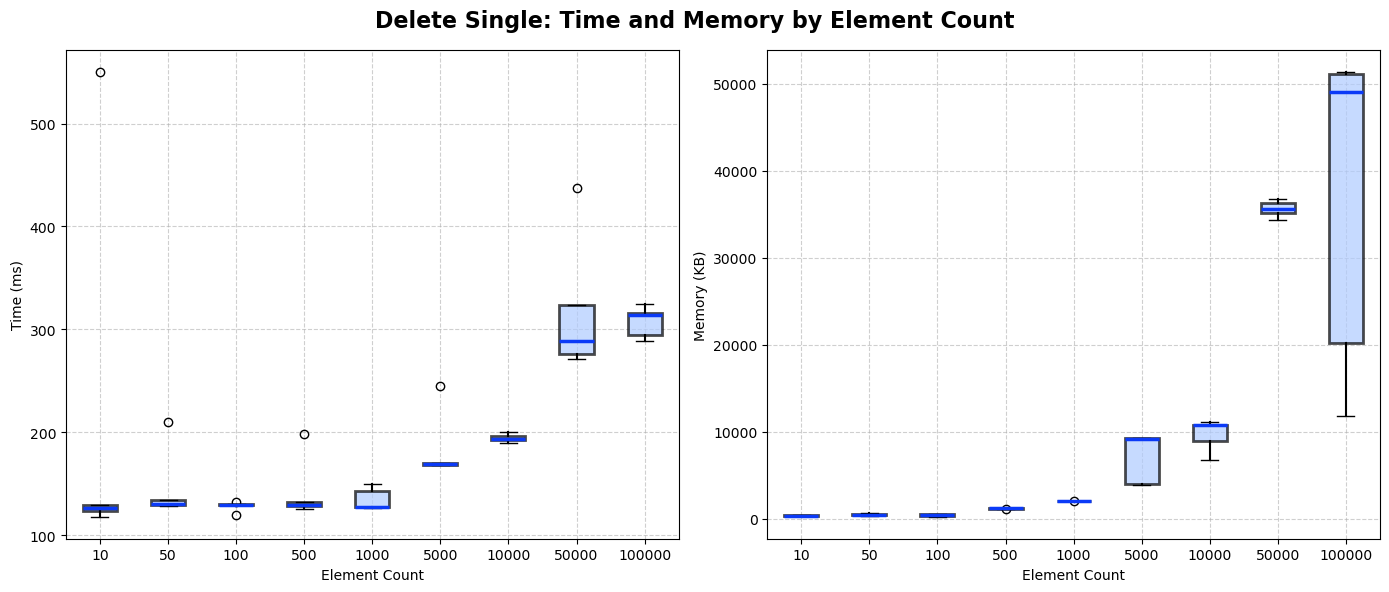

In [370]:
import matplotlib.pyplot as plt

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for time
delete_s_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count')
axes[0].set_ylabel('Time (ms)')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Boxplot for memory
delete_s_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count')
axes[1].set_ylabel('Memory (KB)')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')

plt.suptitle('Delete Single: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()